In [ ]:
# Model 구성
import tensorflow as tf
from tensorflow import keras

# dataset, CV 전처리
from PIL import Image
import os
import io
import cv2
import math
import glob
from sklearn.model_selection import train_test_split

# utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import copy

In [ ]:
"""
# 일회성 : path + label 지정 및 전처리

df = pd.DataFrame(columns = ['path', 'label'])
df_re1 = pd.DataFrame(columns = ['path', 'label'])
df_re2 = pd.DataFrame(columns = ['path', 'label'])
df_re3 = pd.DataFrame(columns = ['path', 'label'])
df_re4 = pd.DataFrame(columns = ['path', 'label'])

file_list = os.listdir('dataset')

for file in range(len(file_list)):
    file_label = file_list[file].split('_')[2]
    #file_name = str('C:/Users/jdm03/OneDrive/바탕 화면/CV_project/dataset/') + file_list[file]
    file_name = str('./dataset/') + file_list[file]
    df.loc[file] = [file_name, file_label]

df_re1 = df[df['label'] == "기쁨"].head(150)
df_re2 = df[df['label'] == "상처"].head(150)
df_re3 = df[df['label'] == "분노"].head(150)
df_re4 = df[df['label'] == "당황"].head(150)

df_re = pd.concat([df_re1, df_re2, df_re3, df_re4])

df_re.to_csv('C:/Users/jdm03/OneDrive/바탕 화면/CV_project/dataset.csv')
"""

In [ ]:
"""
# 일회성 : 파일명 전환

file_list = os.listdir('dataset')
file_path = 'C:/Users/jdm03/OneDrive/바탕 화면/CV_project/dataset'
num = 0

for nam in file_list:
    file_n = file_list[num].split('_')[1:]
    print(file_n)
    file_new = '_'.join(file_n)
    if len(file_n) != 5:
        num += 1
    else:
        # 기존 파일 경로와 새 파일 경로를 절대 경로로 지정
        old_name = os.path.join(file_path, file_list[num])
        new_name = os.path.join(file_path, file_new)

        # 파일 이름 변경
        try:
            os.rename(old_name, new_name)
            print(f"Renamed: {old_name} -> {new_name}")
        except FileNotFoundError:
            print(f"File not found: {old_name}")
        num += 1
"""


In [ ]:
# 여기서부터 시작

df_train = pd.read_csv('./dataset.csv')
df_train.head(5)

df1 = df_train.copy()

df1 = df1.drop(df1.columns[0], axis = 1)

df1 = df1.replace({'label': "기쁨"}, 0)
df1 = df1.replace({'label': "상처"}, 1)
df1 = df1.replace({'label': "분노"}, 2)
df1 = df1.replace({'label': "당황"}, 3)

df1.head()

In [ ]:
df1['label'].value_counts()

C:\Users\jdm03\AppData\Local\Temp\ipykernel_3212\3949275582.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1 = df1.replace({'label': "당황"}, 3)


label
0    150
1    150
2    150
3    150
Name: count, dtype: int64

In [4]:
def load_image(path):
    try:
        img = Image.open(path).convert('L')  # 흑백 모드로 이미지 열기
        img = img.resize((96, 96))  # 이미지 크기 조정
        return np.array(img) / 255  # 정규화
    except Exception as e:
        print(f"Warning: Could not load image at {path}. Error: {e}")
        return None

In [8]:
# 데이터 준비
xs = np.array(df1['path'])
ys = np.array(df1['label'])

# 데이터셋 분할
train_x, valid_x, train_y, valid_y = train_test_split(xs, ys, test_size=0.2)
train_x, test_x, train_y, test_y = train_test_split(xs, ys, test_size=0.2)

processed_train_images = [load_image(item) for item in train_x]
processed_valid_images = [load_image(item) for item in valid_x]
processed_test_images = [load_image(item) for item in test_x]

train_x = np.array([img for img in processed_train_images if img is not None]).reshape(-1, 96, 96, 1)
valid_x = np.array([img for img in processed_valid_images if img is not None]).reshape(-1, 96, 96, 1)
test_x = np.array([img for img in processed_test_images if img is not None]).reshape(-1, 96, 96, 1)

train_y = tf.keras.utils.to_categorical(train_y, 5)
valid_y = tf.keras.utils.to_categorical(valid_y, 5)
test_y = tf.keras.utils.to_categorical(test_y, 5)

In [9]:
def show_sample(image, label, sample_count=25):
    grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
    grid_cout = min(grid_count, len(image), len(label))
    plt.figure(figsize=(2*grid_count, 2*grid_count))

    for i in range(sample_count):
        plt.subplot(grid_count, grid_count, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image[i].reshape(96, 96), cmap=plt.cm.gray)
        plt.xlabel(label[i], fontsize=14)
    plt.show()

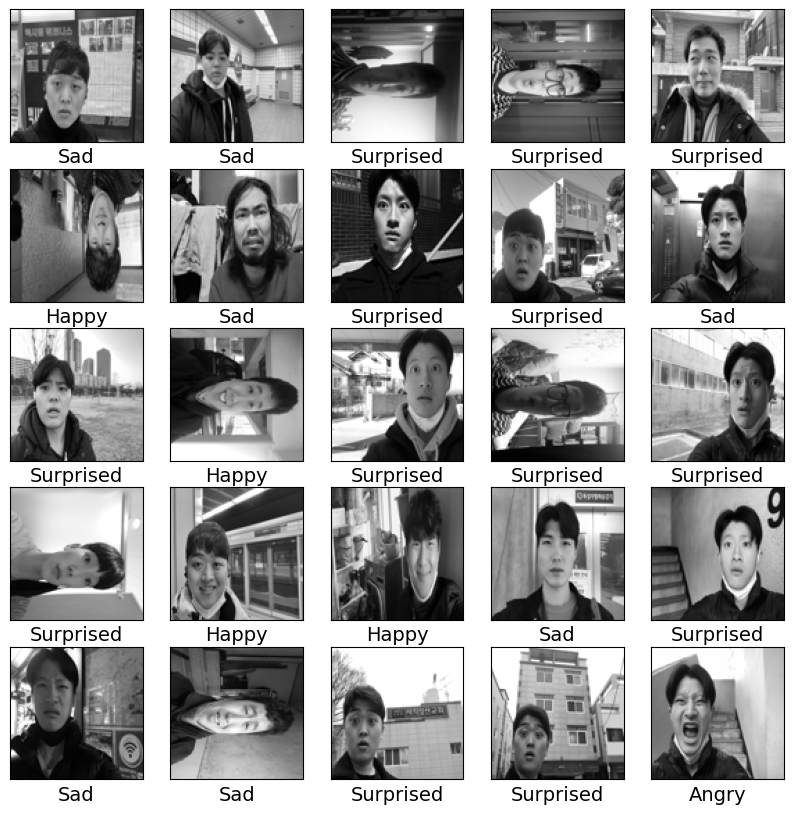

In [10]:
class_to_emotion = {
    '0': 'Happy',
    '1': 'Sad',
    '2': 'Angry',
    '3': 'Surprised',
}

show_sample(train_x, [class_to_emotion[str(cls.argmax())] for cls in train_y])

In [11]:
def bottleneck_residual_block(X, filters, reduce=False, s=2):
    F1, F2, F3 = filters
    X_shortcut = X
    
    if reduce:
        X = keras.layers.Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
        X = keras.layers.BatchNormalization(axis=3)(X)
        X = keras.layers.ReLU()(X)
        
        X_shortcut = keras.layers.Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X_shortcut)
        X_shortcut = keras.layers.BatchNormalization(axis=3)(X_shortcut)
    else: 
        X = keras.layers.Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
        X = keras.layers.BatchNormalization(axis=3)(X)
        X = keras.layers.ReLU()(X)
    
    X = keras.layers.Conv2D(filters=F2, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3)(X)
    X = keras.layers.ReLU()(X)

    X = keras.layers.Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3)(X)

    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.ReLU()(X)
    
    return X

def ResNet50(classes):
    X_input = keras.layers.Input(shape=[96, 96, 1])

    X = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=keras.initializers.glorot_uniform(seed=0))(X_input)
    X = keras.layers.BatchNormalization(axis=3)(X)
    X = keras.layers.ReLU()(X)
    X = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = bottleneck_residual_block(X, [64, 64, 256], reduce=True, s=1)
    X = bottleneck_residual_block(X, [64, 64, 256])
    X = bottleneck_residual_block(X, [64, 64, 256])

    X = bottleneck_residual_block(X, [128, 128, 512], reduce=True)
    X = bottleneck_residual_block(X, [128, 128, 512])
    X = bottleneck_residual_block(X, [128, 128, 512])
    X = bottleneck_residual_block(X, [128, 128, 512])

    X = bottleneck_residual_block(X, [256, 256, 1024], reduce=True)
    X = bottleneck_residual_block(X, [256, 256, 1024])
    X = bottleneck_residual_block(X, [256, 256, 1024])
    X = bottleneck_residual_block(X, [256, 256, 1024])
    X = bottleneck_residual_block(X, [256, 256, 1024])
    X = bottleneck_residual_block(X, [256, 256, 1024])

    X = bottleneck_residual_block(X, [512, 512, 2048], reduce=True)
    X = bottleneck_residual_block(X, [512, 512, 2048])
    X = bottleneck_residual_block(X, [512, 512, 2048])

    X = keras.layers.AveragePooling2D((1,1))(X)

    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(units=512, activation='relu')(X)
    X = keras.layers.Dense(units=classes, activation='softmax')(X)
    
    model = keras.models.Model(inputs=X_input, outputs=X)

    return model

In [12]:
model = ResNet50(5)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 45, 45,    │      3,200 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 45, 45,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 45, 45,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 22, 22,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 22, 22,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 22, 22,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 22, 22,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 22, 22,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 22, 22,    │     16,640 │ re_lu_2[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 22, 22,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 22, 22,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 22, 22,    │          0 │ add[0][0]       

 Total params: 33,021,701 (125.97 MB)

 Trainable params: 32,968,581 (125.77 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
start_time = time.time()

callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_x, train_y, validation_data=(valid_x, valid_y),
    epochs=50, batch_size=16, callbacks=[callbacks]
)

print(f'{time.time() - start_time}초 동안 학습함.')

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 736ms/step - accuracy: 0.2930 - loss: 13.8440 - val_accuracy: 0.3000 - val_loss: 1.4689
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 519ms/step - accuracy: 0.2504 - loss: 3.9365 - val_accuracy: 0.3000 - val_loss: 1.4760
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 652ms/step - accuracy: 0.2859 - loss: 4.2472 - val_accuracy: 0.2167 - val_loss: 1.4568
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 651ms/step - accuracy: 0.2687 - loss: 1.6126 - val_accuracy: 0.3000 - val_loss: 1.4005
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 528ms/step - accuracy: 0.4325 - loss: 1.3241 - val_accuracy: 0.3000 - val_loss: 1.5652
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 533ms/step - accuracy: 0.5065 - loss: 1.2388 - val_accuracy: 0.3000 - val_loss: 1.5186
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 560ms/step - accuracy: 0.5546 - loss: 0.8789 - val_accuracy: 0.3000 - val_loss: 2.0326
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 534ms/step - accuracy: 0.6838 - loss: 0.7968 - val_acc

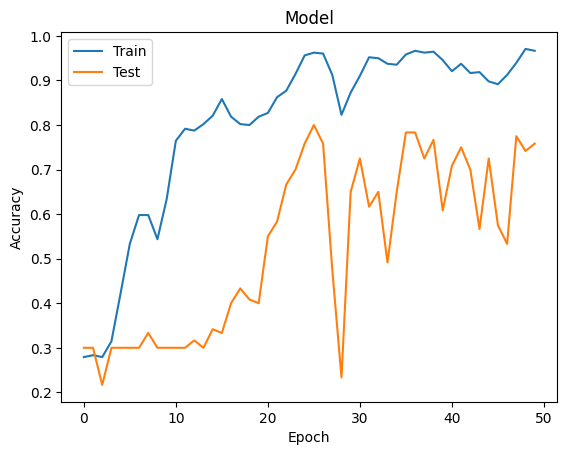

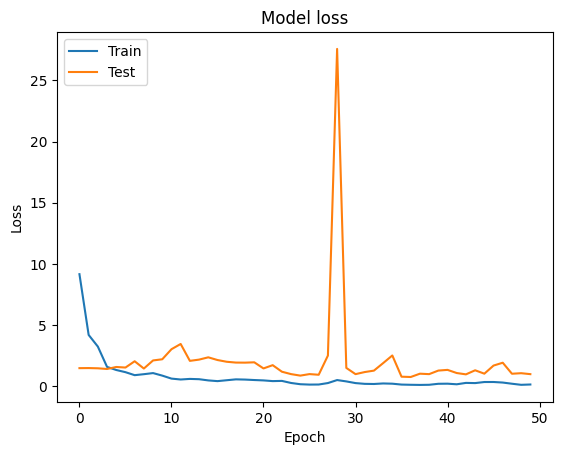

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
model = keras.models.load_model('model.keras')
pred = model.predict(test_x)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 673ms/step


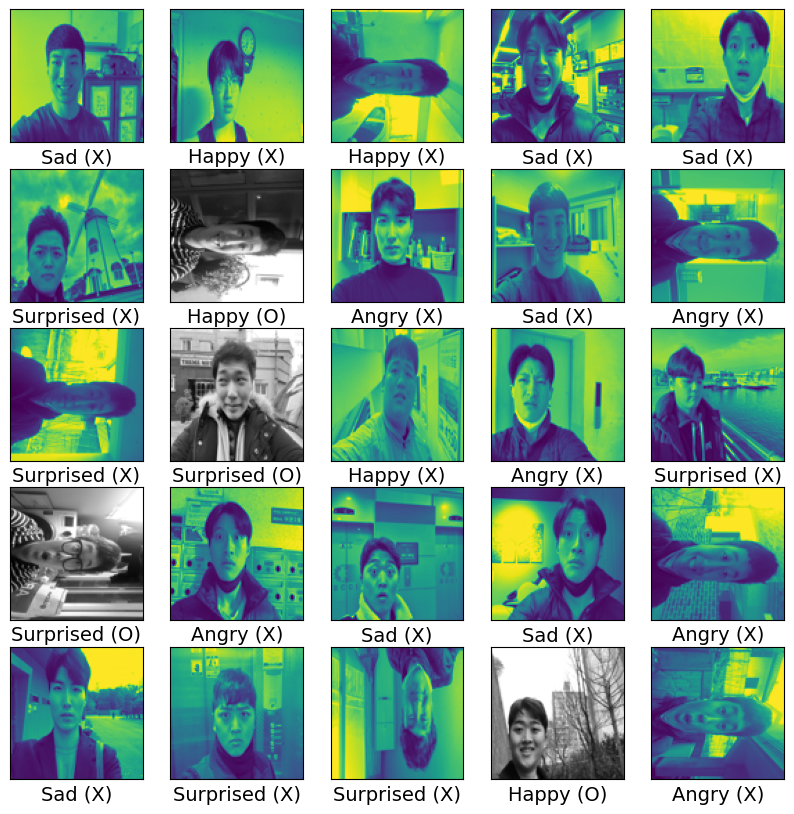

In [16]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    is_correct = 'O' if np.argmax(pred[i]) == np.argmax(test_y[i]) else 'X'
    plt.imshow(test_x.reshape(-1, 96, 96)[i], cmap=plt.cm.gray if np.argmax(pred[i]) == np.argmax(test_y[i]) else None)
    plt.xlabel(f'{class_to_emotion[str(np.argmax(pred[i]))]} ({is_correct})', fontsize=14)
plt.show()